In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
# from google.colab import files
# files.upload()

In [3]:
# my_file = open("count_colors.txt", "r")
# count_colors = my_file.read()
# count_colors = count_colors.split(", ")
# for i in range(23):
#     count_colors[i] = float(count_colors[i])

# print(count_colors)

In [4]:
!kaggle datasets download bulentsiyah/semantic-drone-dataset -p /content/sample_data/ --unzip

 99% 3.86G/3.89G [00:20<00:00, 221MB/s]
100% 3.89G/3.89G [00:20<00:00, 204MB/s]


In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

# !pip install -q torchsummary

from torchsummary import summary
import statistics 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
IMAGE_PATH = '../content/sample_data/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../content/sample_data/dataset/semantic_drone_dataset/label_images_semantic/'

In [7]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [8]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


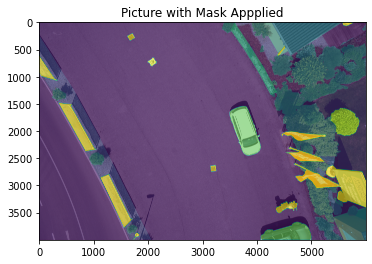

In [9]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [10]:
class DroneDataset(Dataset):

  def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform
    self.patches = patch
    self.mean = mean
    self.std = std
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [11]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [12]:
# import numpy

# t_find = A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST)
# find_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_find, patch=False)

# count_colors = [0] 
# count_colors *= 23

# for i in range(306):
#     # print(count_colors)
#     _ , mask = find_set[i]
#     np_mask = mask.numpy()

#     unique, counts = numpy.unique(np_mask, return_counts=True)
#     for j, i in enumerate(unique):
#         count_colors[i] += counts[j]

# print(count_colors)

In [13]:
# x = sum(count_colors)
# for i in range(23):
#     count_colors[i] /= x

# print(count_colors)

In [14]:
list_of_colors = []

In [15]:
# for j, i in enumerate(count_colors):
#     if i/sum(count_colors) < 0.005:
#         list_of_colors.append(j)
#         print(j)
#     # print(i)
#     # print(i/sum(count_colors))

In [16]:
# list_of_colors = [0, 12, 14, 16, 18, 21]
# weights = []
# for i in range(23):
#     if (i in list_of_colors):
#         weights.append(5.0)
#     else:
#         weights.append(1.0)
#     # for j in list_of_colors:
#     #     if i == j:
#     #         weights.append(5.0)
#     #         continue
#     # weights.append(1.0)

# class_weights = torch.FloatTensor(weights).cuda()

In [17]:
# print(weights)

In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x1 = self.relu(self.bnorm1(self.conv1(x)))
        x2 = self.relu(self.bnorm2(self.conv2(x1)))
        return x2

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.mpool = nn.MaxPool2d(kernel_size = 3, stride = 2)

    def forward(self, x):
        return self.conv(self.mpool(x))

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear')

    def forward(self, x1, x2):
        x1 = self.upsample(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x1 = torch.cat([x2, x1], 1)
        return self.conv(x1)

In [19]:
class GSA(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.M_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.N_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.W_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        M = self.M_conv(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        N = self.N_conv(x).view(batch_size, -1, height * width)
        W = self.W_conv(x).view(batch_size, -1, height * width)
        B = F.softmax(torch.bmm(M, N), dim = -1).permute(0, 2, 1)
        result = torch.bmm(W, B).view(batch_size, channels, height, width)
        
        return self.gamma * result + x

In [20]:
class Position_Encoding(nn.Module):
    def __init__(self, num_pos_feats=256, len_embedding=32):
        super().__init__()
        self.row_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.col_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list):
        x = tensor_list
        h, w = x.shape[-2:]
        i = torch.arange(w, device = x.device)
        j = torch.arange(h, device = x.device)

        x_emb = self.col_embed(i)
        y_emb = self.col_embed(j)

        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim = -1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)

        return pos

class Scalar_dot_product_attention(nn.Module):
    def __init__(self, coef):
        super().__init__()
        self.d_k = coef ** 0.5
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        q = x.view(batch_size, channels, -1)
        k = x.view(batch_size, channels, -1).permute(0, 2, 1)
        v = x.view(batch_size, channels, -1)
        attention = F.softmax(torch.matmul(q / self.d_k, k), dim = -1)
        attention = self.dropout(attention)
        return torch.matmul(attention, v).view(batch_size, channels, height, width)

In [45]:
class Unet(nn.Module):
    def __init__(self, number_of_classes):
        super().__init__()
        self.first_conv = DoubleConv(3, 64)

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512 // 2)
        # self.down4 = Down(512, 1024 // 2)

        # self.up1 = Up(1024, 512 // 2)
        self.up1 = Up(512, 256 // 2)
        self.up2 = Up(256 * 2, 128 // 2)
        self.up3 = Up(128 * 2, 64)
        self.out = nn.Conv2d(64 * 2, number_of_classes, kernel_size = 1)

        self.pos = Position_Encoding(256)
        self.gsa = GSA(512)
        self.prod = Scalar_dot_product_attention(512)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        # x5 = self.down4(x4)

        # x5_gsa = self.gsa(x5)
        # x5 += self.pos(x5)
        # x5_prod = self.prod(x5)
        # x5 = x5_gsa + x5_prod

        # x6 = self.up1(x5, x4)
        # x5_scale = F.interpolate(x5, size = x6.shape[2:], mode = 'bilinear', align_corners=True)
        # x6_cat = torch.cat((x6, x5_scale), 1)

        x5 = self.up2(x4, x3)
        x4_scale = F.interpolate(x4, size = x5.shape[2:], mode = 'bilinear', align_corners=True)
        x5_cat = torch.cat((x4_scale, x5), 1)
                
        x6 = self.up3(x5_cat, x2)
        x5_scale = F.interpolate(x5, size = x6.shape[2:], mode = 'bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)
        
        x7 = self.up4(x6_cat, x1)
        x6_scale = F.interpolate(x6, size = x7.shape[2:], mode = 'bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        return self.out(x7_cat)

In [46]:
# model = UNET(3, 23)
# optimizer = torch.optim.Adam(model.parameters())

# epochs = 15

In [47]:
# print(error)

In [48]:
import torch
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/1024/1024)

5095.62548828125


In [49]:
# checkpoint = torch.load('dice_7ep.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model = model.cuda()

In [50]:
# weights = []
# for i in class_accuracy:
#     if (i < 0.05):
#         weights.append(5.0)
#     elif (i > 0.5):
#         weights.append(0.7)
#     else:
#         weights.append(1.0)
# print(weights)
# class_weights = torch.FloatTensor(weights).cuda()

In [51]:
# len(weights)

In [52]:
# criterion = nn.CrossEntropyLoss(weight=class_weights)

In [53]:
# print(output.shape)
# print(y.shape)

In [54]:
# model.cuda()

In [55]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        # self.alpha = alpha
        # if isinstance(alpha,(float, int, long)): self.alpha = torch.Tensor([alpha,1-alpha])
        # if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
        input = input.transpose(1, 2)    # N,C,H*W => N,H*W,C
        input = input.contiguous().view(-1, input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, -1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()
        pt.requiers_grad = True
        # if self.alpha is not None:
        #     if self.alpha.type() != input.data.type():
        #         self.alpha = self.alpha.type_as(input.data)
        #     at = self.alpha.gather(0,target.data.view(-1))
        #     logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()

In [56]:
# criterion = FocalLoss(gamma = 2)

In [57]:
# class TverskyLoss(nn.Module):
#     def __init__(self, alpha=0.5, beta=0.5, eps=1e-7):
#         super(TverskyLoss, self).__init__()
#         self.alpha = alpha
#         self.beta = beta
#         self.eps = eps

#     def forward(self, true, logits):
#         true = true.long()
#         true = logits.long()
#         num_classes = logits.shape[1]
#         true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
#         true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
#         probas = F.softmax(logits, dim=1)

#         true_1_hot = true_1_hot.type(logits.type())
#         dims = (0,) + tuple(range(2, true.ndimension()))
#         intersection = torch.sum(probas * true_1_hot, dims)
#         fps = torch.sum(probas * (1 - true_1_hot), dims)
#         fns = torch.sum((1 - probas) * true_1_hot, dims)
#         num = intersection
#         denom = intersection + (self.alpha * fps) + (self.beta * fns)
#         tversky_loss = (num / (denom + self.eps)).mean()

#         return (1 - tversky_loss)

In [58]:
# criterion = TverskyLoss()

In [59]:
smooth = 1

all_colors = [0] * 24
correct_colors = [0] * 24
guessed_colors = [0] * 24
loss = []


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, output, y):
        smooth = 1
        all_colors = [0] * 24
        correct_colors = [0] * 24
        guessed_colors = [0] * 24
        loss = []

        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        output += 1
        y += 1
        correct = torch.eq(output, y).int()
        correct = correct.cuda()

        # incorrect = torch.ne(output, y).int()
        # incorrect = correct.cuda()

        output = output.cpu()
        np_output = output.numpy()
        unique_output, counts_output = np.unique(np_output, return_counts=True)
        output = output.cuda()

        output = output * correct
        y = y.cpu()
        np_y = y.numpy()
        unique_y, counts_y = np.unique(np_y, return_counts=True)
            
        for j, i in enumerate(unique_y):
            guessed_colors[i] += counts_y[j]

        output = output.cpu()
        np_output = output.numpy()
        unique_output, counts_output = np.unique(np_output, return_counts=True)

        for j, i in enumerate(unique_y):
            all_colors[i] += counts_y[j]

        for j, i in enumerate(unique_output):
            correct_colors[i] += counts_output[j]

        for i in range(23):
            if (count_colors[i] > 0.04):
                if (count_colors[i] > 0.1):
                    loss.append(2 * correct_colors[i] * 0.01 / (all_colors[i] + guessed_colors[i] + smooth))
                else:
                    loss.append(2 * correct_colors[i] * 0.1 / (all_colors[i] + guessed_colors[i] + smooth))
            else:
                loss.append(2 * correct_colors[i] / (all_colors[i] + guessed_colors[i] + smooth))

        return statistics.mean(loss)
    # for j, i in enumerate(unique_output):
    #     incorrect_colors[i] += counts_output[j]

In [60]:
def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    
    # true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
    true_1_hot = torch.eye(num_classes)
    # print(true_1_hot)
    true_1_hot = true_1_hot.cuda()
    true_1_hot = true_1_hot[true.squeeze(1)]
    # print(true_1_hot.shape)

    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    # print(true_1_hot.shape)
    probas = F.softmax(logits, dim=1)

    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    # print(intersection)
    # print(cardinality)

    dice_loss = (2. * intersection / (cardinality + eps)).mean()

    return (1 - dice_loss)

In [61]:
# weights = torch.eye(23)
# lst = []
# for i in range(23):
#     if count_colors[i] > 0.04:
#         if count_colors[i] > 0.1:
#             weights[i][i] = 0.1
#             lst.append(0.1)
#         else:
#             weights[i][i] = 0.5
#             lst.append(0.5)

#     else:
#         weights[i][i] = 1.0
#         lst.append(1.0)

# x = statistics.mean(lst)
# for i in range(23):
#     weights[i][i] /= x

In [62]:
# weight = []
# for i in range(23):
#     if count_colors[i] > 0.04:
#         if count_colors[i] > 0.1:
#             weight.append(0.05)
#         else:
#             weight.append(0.5)
#     else:
#         weight.append(1.0)

# x = statistics.mean(weight)

# for i in range(23):
#     weight[i] = weight[i] / x

In [63]:
# for x, y in val_loader:
#     x = x.cuda()
#     y = y.cuda()
#     model.cuda()

#     with torch.no_grad():
#         output = model(x)
#         print(eddynet_dice(y.long(), output))
#         break

In [64]:
# print(count_colors)

In [65]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()
    train_loss, valid_loss = [], []
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl
            running_loss = 0.0
            running_acc = 0.0
            step = 0
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)
                    # loss = loss_fn(outputs, y)
                    loss = dice_loss(y.long(), outputs)

                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        # loss = loss_fn(outputs, y.long())

                        loss = dice_loss(y.long(), outputs)
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 
                if step % 10 == 0:
                    print('Current step: {}  Loss: {}  Acc: {}   AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model.pt')
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [66]:
# criterion = DiceLoss()

In [67]:
# !pip install -q segmentation-models-pytorch
# import segmentation_models_pytorch as smp

# model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
# # criterion = FocalLoss(gamma = 2)
# criterion = DiceLoss()

# # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
#                                             # steps_per_epoch=len(train_loader))
criterion = nn.CrossEntropyLoss()
model = Unet(23)
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
train_loss, valid_loss = train(model, train_loader, val_loader, criterion, optimizer, pixel_accuracy, epochs=50)
# fit()

In [ ]:
all_colors = [0] * 24
correct_colors = [0] * 24

for x, y in val_loader:
    x = x.cuda()
    y = y.cuda()
    model.cuda()

    with torch.no_grad():
        output = model(x)
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        output += 1
        y += 1
        correct = torch.eq(output, y).int()
        correct = correct.cuda()
        output = output * correct
        y = y.cpu()
        np_y = y.numpy()
        unique_y, counts_y = np.unique(np_y, return_counts=True)
        
        output = output.cpu()
        np_output = output.numpy()
        unique_output, counts_output = np.unique(np_output, return_counts=True)

        for j, i in enumerate(unique_y):
            all_colors[i] += counts_y[j]

        for j, i in enumerate(unique_output):
            correct_colors[i] += counts_output[j]


print(all_colors[1:24])
print(correct_colors[1:24])

class_accuracy = []
for i in range(1, 24):
    class_accuracy.append(correct_colors[i] / all_colors[i])

with open("dice_10ep.txt", "w") as output:
    output.write(str(class_accuracy))

print(class_accuracy)

In [ ]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [ ]:
image, mask = test_set[0]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()

In [ ]:
image, mask = test_set[1]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()

In [ ]:
image, mask = test_set[2]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()